In [1]:
import os
%matplotlib inline
# Prevent CUDA from using GPU as it does not work well on my pc
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
H5_OUPUT_FILENAME = "test_epoch.h5"
IMPORT_DATA_FILENAME = 'data_train.npy'
IMPORT_LABELS_FILENAME = 'labels_train.npy'

# Set Constants of the model
BATCH_SIZE = 64

In [2]:
# Helper functions
import numpy as np

# Breaks down a list of integer values into a one-hot like format
def one_hot_training(np_array):
    transformed_list = []
    for arr in np_array:
        new_arr = np.zeros(10)
        new_arr[int(arr)] = 1
        transformed_list.append(new_arr)
    return np.array(transformed_list)

# This translates the highest value from the one-hot encoding into the correct sign name
def one_hot_translator(np_array):
    labels_names = ['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only',
                'Do Not Enter','Crosswalk','Handicap Parking','No Parking']
    #return labels_names[np.argmax(np_array)]
    return np.argmax(np_array)

# This translates the highest value from the one-hot encoding into the correct sign name
def one_hot_translator_thres(np_array):
    max_index = np.argmax(np_array)
    max_value = np.max(np_array)
    if max_value <= 0.8071025020177562:
        return -1
    return max_index

# This translates an entire array of one-hot encoded sign predictions
def translate_all(np_array):
    translated_values = []
    for i in np_array:
        translated_values.append(one_hot_translator(i))
    return np.array(translated_values)

# This translates an entire array of one-hot encoded sign predictions
def translate_all_thres(np_array):
    translated_values = []
    for i in np_array:
        translated_values.append(one_hot_translator_thres(i))
    return np.array(translated_values)

In [3]:
# First import the data
import tensorflow as tf
data_train = np.load(IMPORT_DATA_FILENAME).transpose()
labels_train = np.load(IMPORT_LABELS_FILENAME)
data_train = np.array([i.reshape(300,300,3) for i in data_train])
data_train = np.array(tf.cast(tf.image.resize(data_train,(150,150)), np.uint8))

In [4]:
# Process the data so that it is in the expected form for the InceptionV3 model
import tensorflow as tf
processed = tf.keras.applications.inception_v3.preprocess_input(data_train, data_format=None)

# Break down data into training and test sets
from sklearn.model_selection import train_test_split
x_train, x_test, t_train, t_test = train_test_split(processed, one_hot_training(labels_train), test_size=0.20, random_state=1)

In [5]:
# Augment data to reduce overfitting
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=True,
                                   rotation_range=90,
                                   brightness_range=(.75, 1))

train_generator = train_datagen.flow(
    x_train,
    y = t_train,
    batch_size=BATCH_SIZE)

In [6]:
# Import the InceptionV3 Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception = InceptionV3(input_shape=(150,150,3),
                       include_top=False,
                       weights='imagenet')

# Set layers to false to prevent overwriting the existing model
for layer in inception.layers:
    layer.trainable = False

# Create output layers that will be trained
from tensorflow.keras.optimizers import SGD
x = tf.keras.layers.Flatten()(inception.output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.15)(x)
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create Optimizer
Adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam') 
Nadam = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07,name='Nadam') 
SGD = SGD(learning_rate=0.01, nesterov=True)
optimizer = SGD

# Finalize and compile the model
model = tf.keras.Model(inception.input, outputs = x)
model.compile(optimizer = optimizer,
             loss = 'categorical_crossentropy',
             metrics = ['categorical_accuracy', 'acc','mean_squared_error'])

In [8]:
# Fit the model to the dataset
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=H5_OUPUT_FILENAME,monitor='loss',verbose=0,save_best_only=True,mode='min')
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=15)
history = model.fit(train_generator, epochs=200, callbacks=[es])
#model.save(H5_OUPUT_FILENAME)

Epoch 1/200
78/78 [==============================] - 30s 293ms/step - loss: 1.8864 - categorical_accuracy: 0.7070 - acc: 0.7070 - mean_squared_error: 0.0442
Epoch 2/200
78/78 [==============================] - 23s 288ms/step - loss: 0.4418 - categorical_accuracy: 0.8697 - acc: 0.8697 - mean_squared_error: 0.0193
Epoch 3/200
78/78 [==============================] - 22s 277ms/step - loss: 0.3857 - categorical_accuracy: 0.8884 - acc: 0.8884 - mean_squared_error: 0.0168
Epoch 4/200
78/78 [==============================] - 23s 291ms/step - loss: 0.3428 - categorical_accuracy: 0.9003 - acc: 0.9003 - mean_squared_error: 0.0151
Epoch 5/200
78/78 [==============================] - 23s 294ms/step - loss: 0.2979 - categorical_accuracy: 0.9173 - acc: 0.9173 - mean_squared_error: 0.0128
Epoch 6/200
78/78 [==============================] - 22s 281ms/step - loss: 0.2935 - categorical_accuracy: 0.9118 - acc: 0.9118 - mean_squared_error: 0.0130
Epoch 7/200
78/78 [==============================] - 22s 2

78/78 [==============================] - 22s 278ms/step - loss: 0.0885 - categorical_accuracy: 0.9736 - acc: 0.9736 - mean_squared_error: 0.0042
Epoch 53/200
78/78 [==============================] - 22s 280ms/step - loss: 0.0907 - categorical_accuracy: 0.9726 - acc: 0.9726 - mean_squared_error: 0.0043
Epoch 54/200
78/78 [==============================] - 22s 277ms/step - loss: 0.0882 - categorical_accuracy: 0.9738 - acc: 0.9738 - mean_squared_error: 0.0042
Epoch 55/200
78/78 [==============================] - 22s 278ms/step - loss: 0.0796 - categorical_accuracy: 0.9768 - acc: 0.9768 - mean_squared_error: 0.0037
Epoch 56/200
78/78 [==============================] - 22s 278ms/step - loss: 0.0839 - categorical_accuracy: 0.9738 - acc: 0.9738 - mean_squared_error: 0.0040
Epoch 57/200
78/78 [==============================] - 22s 276ms/step - loss: 0.0861 - categorical_accuracy: 0.9722 - acc: 0.9722 - mean_squared_error: 0.0042
Epoch 58/200
78/78 [==============================] - 22s 278ms/s

78/78 [==============================] - 22s 278ms/step - loss: 0.0455 - categorical_accuracy: 0.9863 - acc: 0.9863 - mean_squared_error: 0.0022
Epoch 104/200
78/78 [==============================] - 22s 278ms/step - loss: 0.0489 - categorical_accuracy: 0.9855 - acc: 0.9855 - mean_squared_error: 0.0024
Epoch 105/200
78/78 [==============================] - 22s 278ms/step - loss: 0.0510 - categorical_accuracy: 0.9861 - acc: 0.9861 - mean_squared_error: 0.0024
Epoch 106/200
78/78 [==============================] - 22s 280ms/step - loss: 0.0524 - categorical_accuracy: 0.9855 - acc: 0.9855 - mean_squared_error: 0.0024
Epoch 107/200
78/78 [==============================] - 22s 280ms/step - loss: 0.0389 - categorical_accuracy: 0.9901 - acc: 0.9901 - mean_squared_error: 0.0017
Epoch 108/200
78/78 [==============================] - 22s 277ms/step - loss: 0.0443 - categorical_accuracy: 0.9871 - acc: 0.9871 - mean_squared_error: 0.0021
Epoch 109/200
78/78 [==============================] - 22s 2

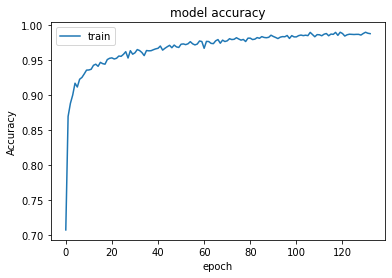

In [9]:
# Plot the progression of the acccuracy through the epochs
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step
7


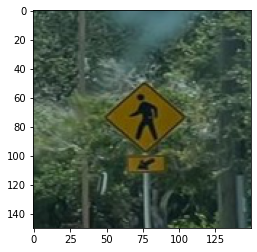

In [10]:
# Demo to randomly pick a sign and demonstrate that it is predicted correctly
from random import randint
test_image = randint(0,len(data_train))
test = np.expand_dims(data_train[test_image], axis=0)
test = tf.keras.applications.inception_v3.preprocess_input(
    test, data_format=None
)
print(one_hot_translator(model.predict(test)))
plt.imshow(data_train[test_image])

In [11]:
# Calculate the predictions for the test values
predictions = model.predict(x_test)

39/39 [==============================] - 3s 52ms/step


In [12]:
evaluation = model.evaluate(x_test, t_test)
print("Test run accuracy is {}".format(evaluation[-2]))

39/39 [==============================] - 3s 35ms/step - loss: 0.3274 - categorical_accuracy: 0.9443 - acc: 0.9443 - mean_squared_error: 0.0095
Test run accuracy is 0.9443099498748779


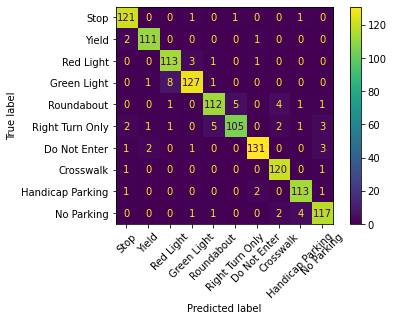

In [26]:
# Create a Confusion Matrix to show the weakness in the model
predicted_values = translate_all(predictions)
real_values = translate_all(t_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cfm = confusion_matrix(real_values, predicted_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=['Stop','Yield','Red Light','Green Light','Roundabout','Right Turn Only','Do Not Enter','Crosswalk','Handicap Parking','No Parking'])
disp.plot(xticks_rotation=45)
plt.show()

In [14]:
# Test Run Data

# Testing optimizers
# NADAM=                                   times = [275,272,286], loss after 3 runs = [19.0231,0.5492,0.4377], accuracy after 3 runs = [0.6372,0.8364,0.8650]
# ADAM=                                    times = [190,186,190], loss after 3 runs = [16.5848,0.5596,0.4106], accuracy after 3 runs = [0.6245,0.8307,0.8763]
# SGD(.001, Nesterov=No, Momentum = No),   times = [182,180,181], loss after 3 runs = [1.1017, 0.5662,0.4399], accuracy after 3 runs = [0.6269,0.8238,0.8660]
# SGD(.01, Nesterov=No, Momentum = No),    times = [180,180,179], loss after 3 runs = [2.6334,0.5418,0.3895], accuracy after 3 runs = [0.5662,0.8210,0.8854]
# SGD(.01, Nesterov=Yes, Momentum = 0.25), times = [183,183,183], loss after 3 runs = [2.8777,0.5341,0.4083], accuracy after 3 runs = [0.5361,0.8234,0.8741]
# SGD(.01, Nesterov=Yes, Momentum = 0.5),  times = [189,183,183], loss after 3 runs = [3.3616,0.4973,0.4002], accuracy after 3 runs = [0.5696,0.8351,0.8763]
# SGD(.01, Nesterov=Yes, Momentum = 0.75), times = [185,185,184], loss after 3 runs = [5.2539,0.5209,0.4359], accuracy after 3 runs = [0.5337,0.8212,0.8606]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


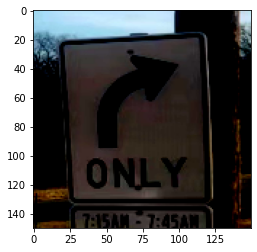

In [15]:
# This method is used to show an example of the post processed test data
from random import randint
import matplotlib.pyplot as plt
test_image = randint(0,len(x_train))
plt.imshow(x_train[test_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


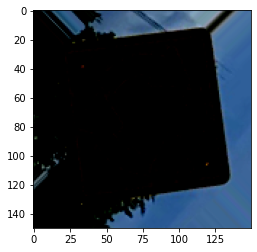

In [16]:
# This method is used to show an example of the augmented test data
from random import randint
x,y = next(train_generator)
plt.imshow(x[randint(0,63)])
plt.show()

In [17]:
# Load an arbitray image and display its predicted value
try:
    Load_image = tf.keras.preprocessing.image.load_img('yield.jpg')
    og_image = Load_image.copy()
    Load_image = np.array(tf.cast(tf.image.resize(Load_image,(150,150)), np.uint8))
    print(Load_image.shape)
    Load_image = tf.keras.applications.inception_v3.preprocess_input(
        Load_image, data_format=None
    )
    Load_image = tf.expand_dims(Load_image,0)
    prediction = model.predict(Load_image)
    print(prediction)
    print(one_hot_translator_thres(prediction))

    plt.plot([0,1,2,3,4,5,6,7,8,9],prediction[0])
    plt.show()
except:
    print("No alternate images")

No alternate images


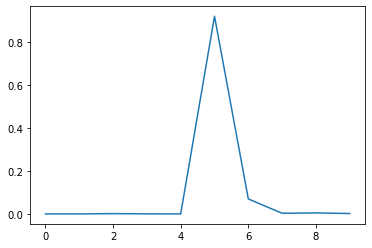

In [18]:

#print(x)
#print(np.argmax(x))
#print(predictions)
rand_image = randint(0,len(predictions))
plt.plot(list(range(0,len(predictions[rand_image]))),predictions[rand_image])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
5
1.0000000654367796


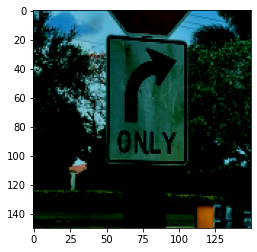

In [19]:
plt.imshow(x_test[rand_image])
print(one_hot_translator(t_test[rand_image]))
print(one_hot_translator(predictions[rand_image]))
print(sum(predictions[rand_image]))

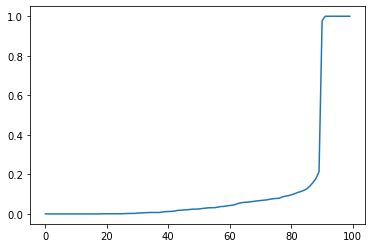

0.008071025020177562


In [20]:
# Find ideal cutoff threshold to facilitate weeding out of Unknown items
max_prediction_value = np.array([i[np.argmax(i)] for i in predictions])
total_len = len(max_prediction_value)
threshold_list = np.arange(.1,1.1,.01)
target_acc = .9
plotter = []
for threshold in threshold_list:
    plotter.append(len(np.where(max_prediction_value < threshold)[0])/total_len)
plt.plot(plotter)
plt.show()
plotter = np.sort(plotter)
print(len(np.where(plotter>target_acc)[0])/total_len)
# Insert vertical line at the 90 percintile cutoff
# Include labels and titles

In [21]:
# Evaluate performance of grading models with the threshold
original_predicted_labels = translate_all(predictions)
threshold_predicted_labels = translate_all_thres(predictions)

preserved_values = 0
for index, i in enumerate(original_predicted_labels):
    if i == threshold_predicted_labels[index]:
        preserved_values = preserved_values + 1
print(preserved_values / len(original_predicted_labels))
    
preserved_values = 0
print(real_values)
print(original_predicted_labels)
for index, i in enumerate(threshold_predicted_labels):
    if i == real_values[index]:
        preserved_values = preserved_values + 1
print(preserved_values / len(original_predicted_labels))


0.9313962873284907
[2 7 7 ... 2 6 7]
[2 7 7 ... 2 6 7]
0.9023405972558515


In [22]:
model.save("inception_v3_trained.h5")